# Importing packages and files

In [1]:
import json
import graphviz
import requests
from IPython.display import display, SVG
from anytree.exporter import DotExporter
import sys

sys.path.append('simulator/src')

URL = "127.0.0.1"
PORT = 8001

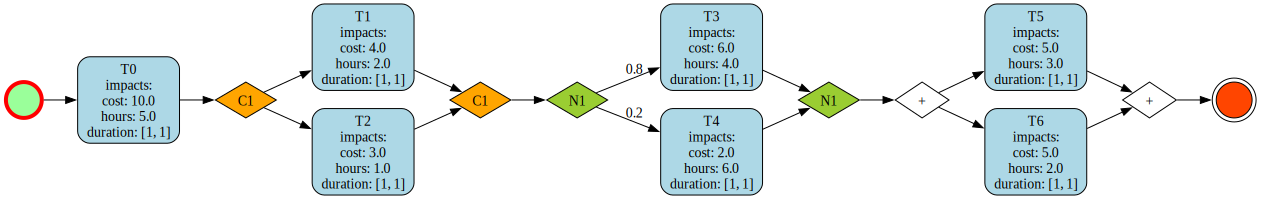

In [2]:
from src.utils.env import EXPRESSION, IMPACTS, DURATIONS, IMPACTS_NAMES, PROBABILITIES, DELAYS, LOOP_PROBABILITY, LOOP_ROUND, H
import graphviz
from IPython.display import display, SVG

# A string that describing the full BPMN structure.
expression = "T0, (T1 / [C1] T2), (T3 ^ [N1] T4), (T5 || T6)"


bpmn = {
	EXPRESSION: expression,
	H: 0,
	# A dictionary mapping task names to impact vectors (e.g., cost and hours)
	IMPACTS: {"T0": [10, 5], "T1": [4, 2], "T2": [3, 1], "T3": [6, 4],
			  "T4": [2, 6], "T5": [5, 3], "T6": [5, 2]},
	# A dictionary mapping task names to [min_time, max_time] execution time
	DURATIONS: {"T0": [1, 1], "T1": [1, 1], "T2": [1, 1], "T3": [1, 1],
				"T4": [1, 1], "T5": [1, 1], "T6": [1, 1]},
	# A list of names corresponding to the dimensions of the impacts
	IMPACTS_NAMES: ["cost", "hours"],
	# A dictionary mapping nature labels to their execution probabilities for the left child.
	PROBABILITIES: {"N1": 0.8},
	# A dictionary mapping choice to their delay values.
	DELAYS: {"C1": 0},
	LOOP_PROBABILITY : {}, LOOP_ROUND: {}
}

try:
	resp = requests.get(f'http://{URL}:{8000}/create_bpmn', json={'bpmn': bpmn},  headers={"Content-Type": "application/json"})
	resp.raise_for_status()
	parse_tree = resp.json()["parse_tree"]
	display(SVG(graphviz.Source(resp.json()['bpmn_dot']).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

# Initialize petri net and execution tree

In [4]:
response = requests.post(f"http://{URL}:{PORT}/execute", headers={"Content-Type": "application/json"},
                         json={"bpmn": parse_tree})
response_json = response.json()

In [5]:
parse_tree = response_json['bpmn']
petri_net = response_json['petri_net']
petri_net_dot = response_json['petri_net_dot']
execution_tree = response_json['execution_tree']
spin_svg = response_json.get('spin_svg')


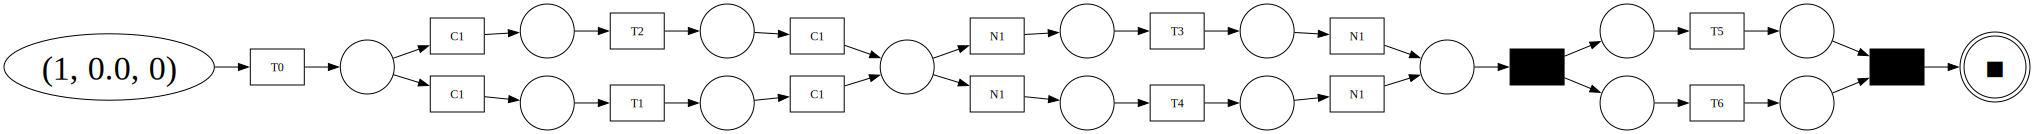

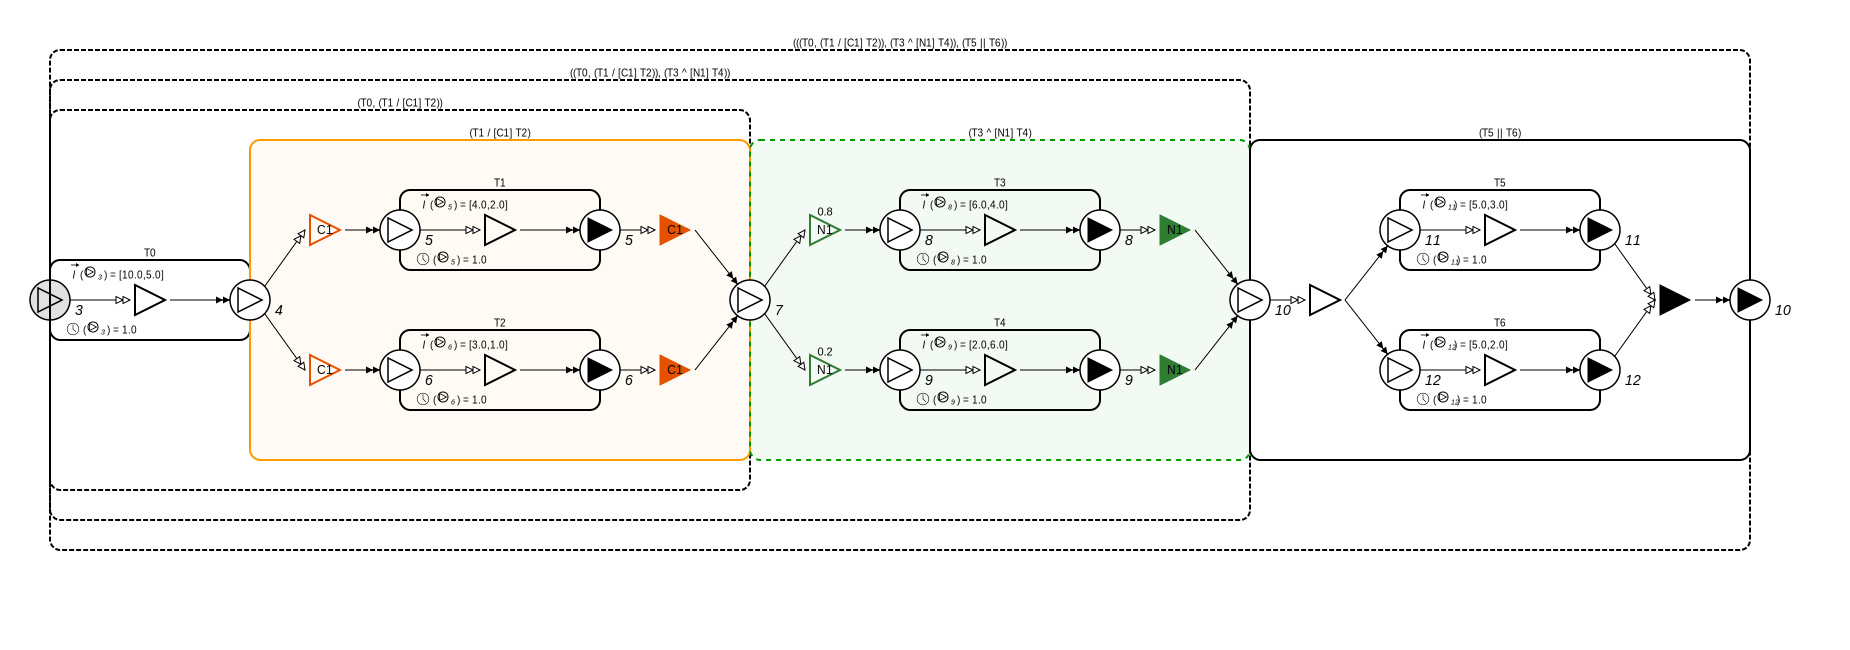

In [6]:
graph = graphviz.Source(petri_net_dot, format="svg")
display(graph)
if spin_svg:
    display(SVG(spin_svg))


# Execute choice

step 1/10: current_node=1


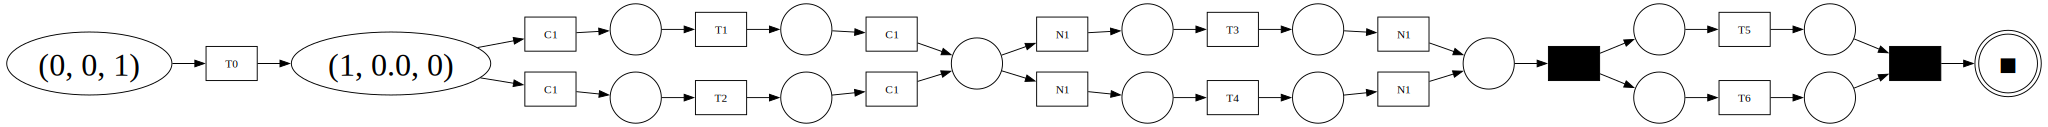

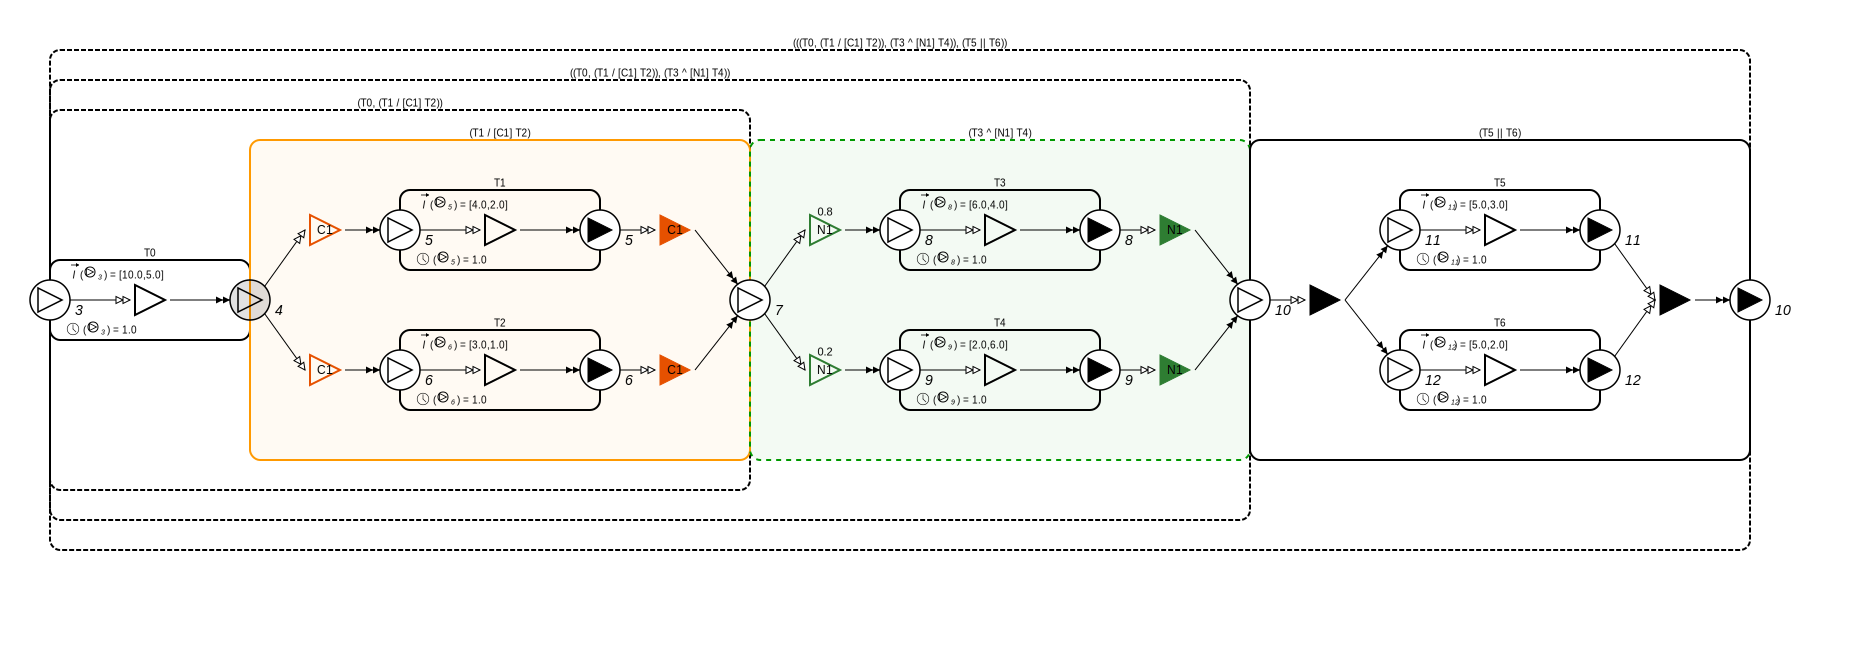

step 2/10: current_node=2


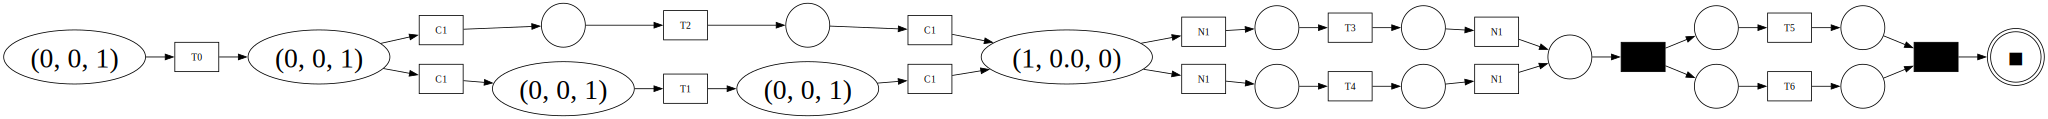

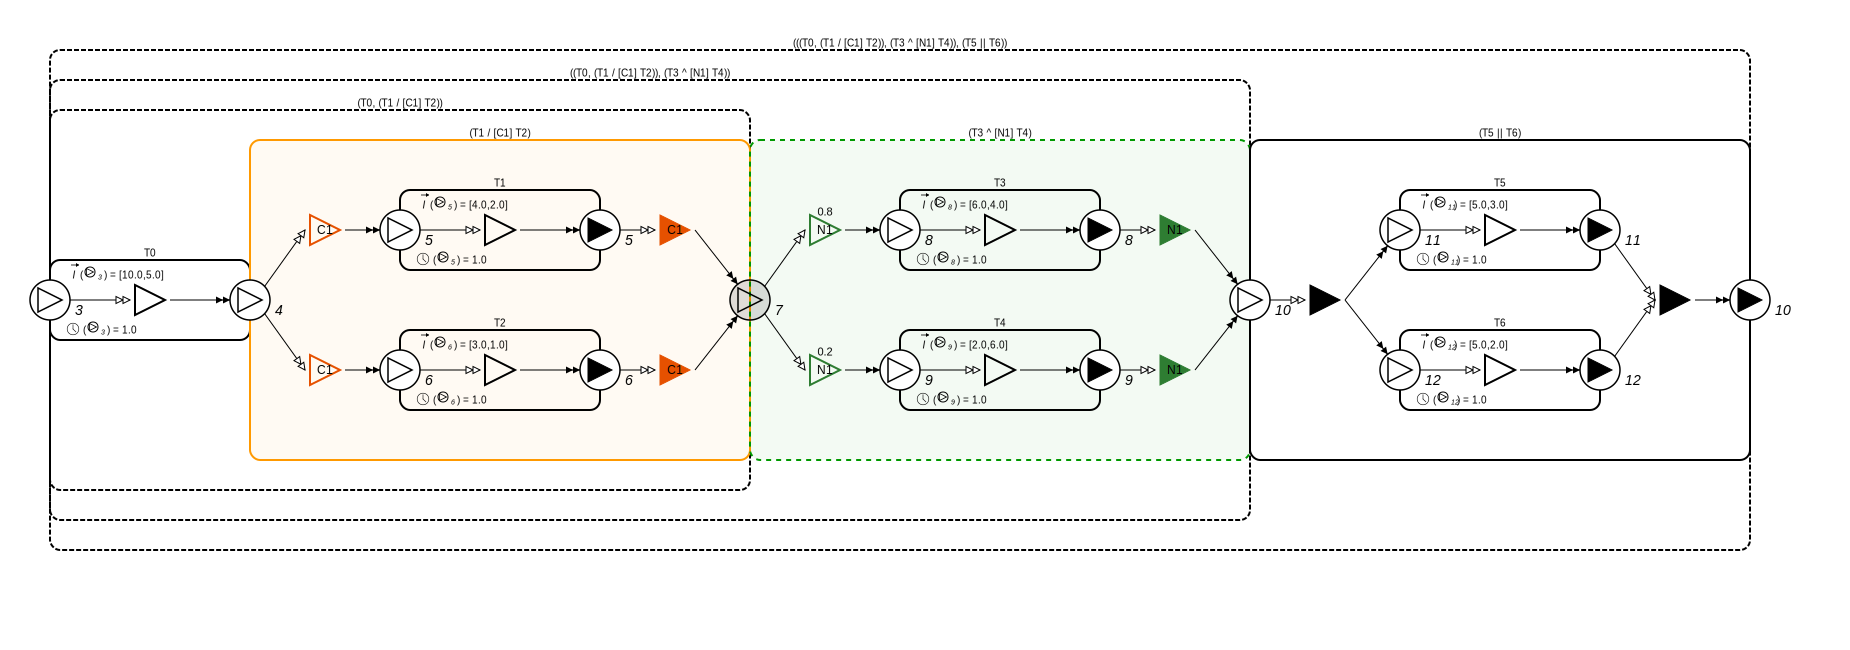

step 3/10: current_node=3


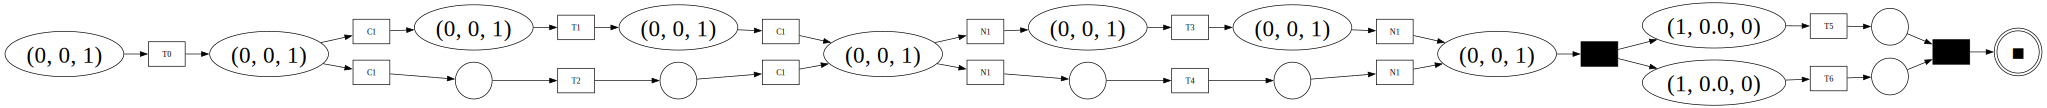

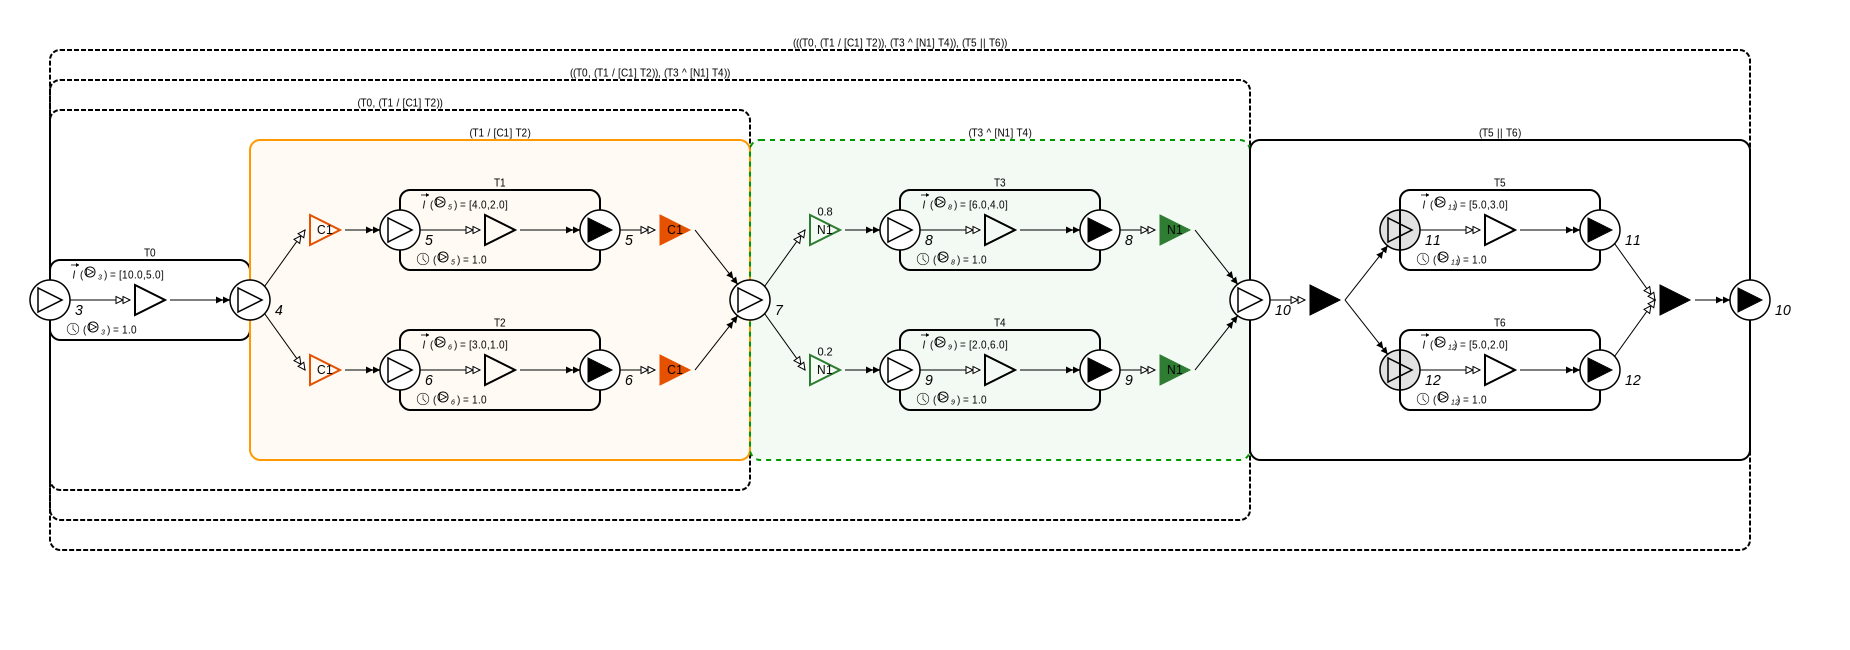

step 4/10: current_node=4


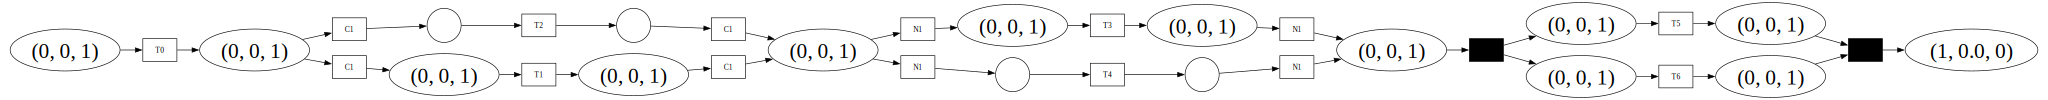

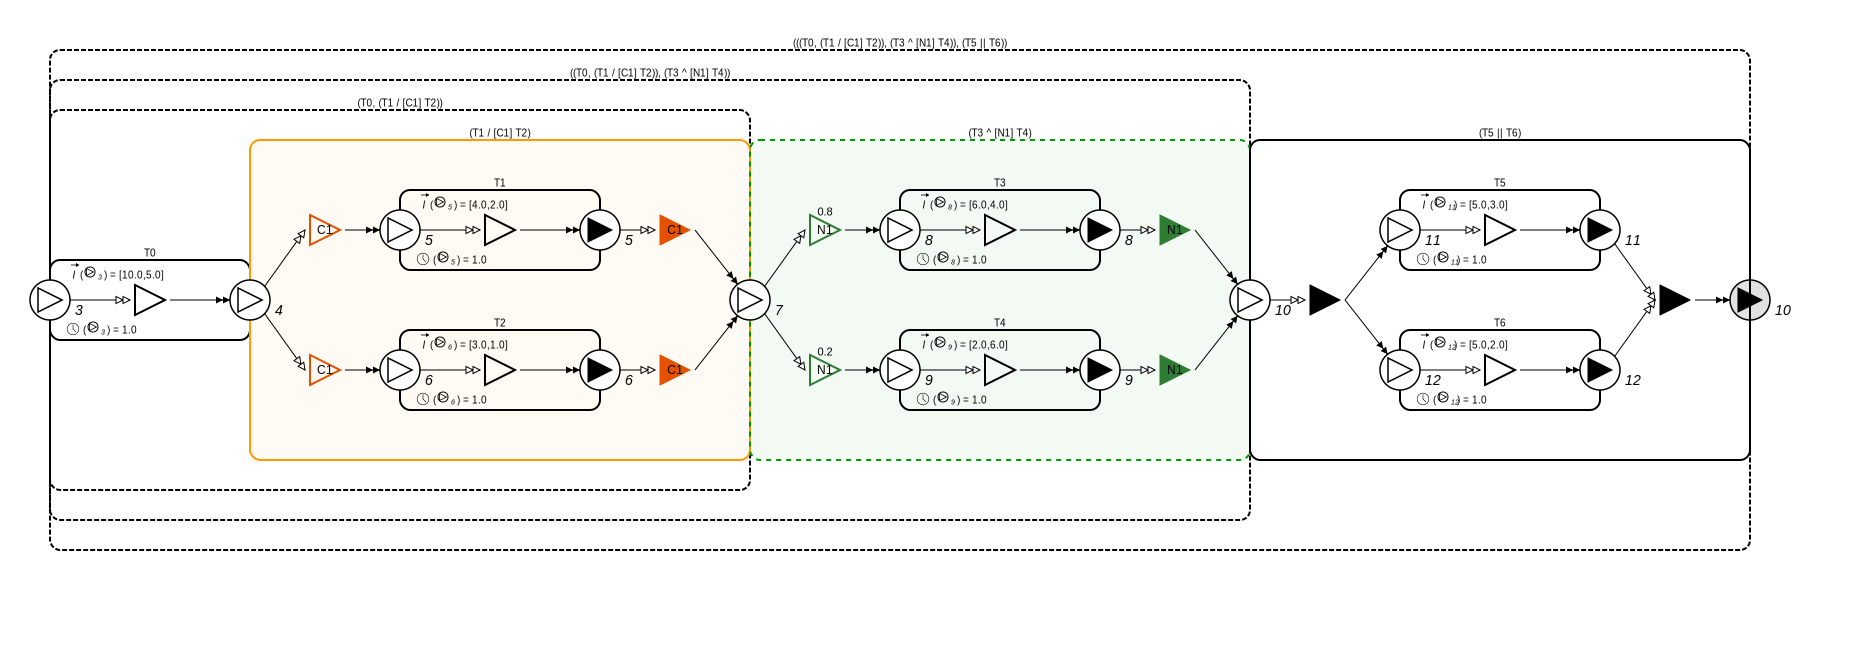

step 5/10: current_node=4


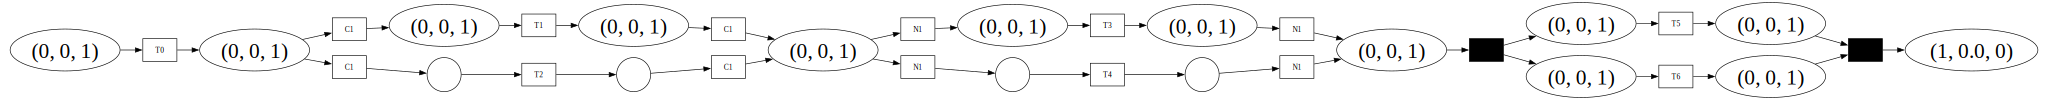

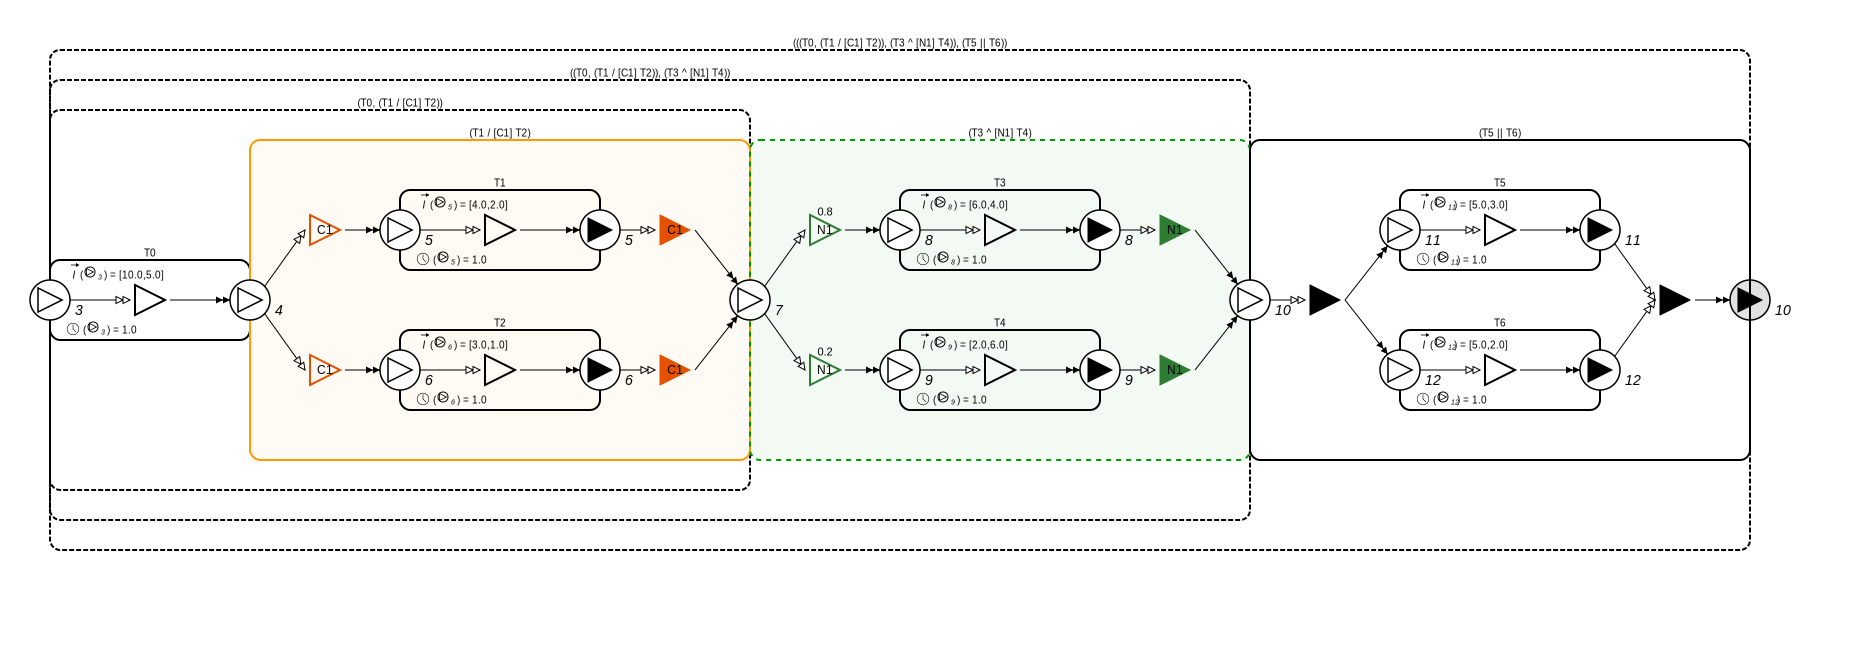

step 6/10: current_node=4


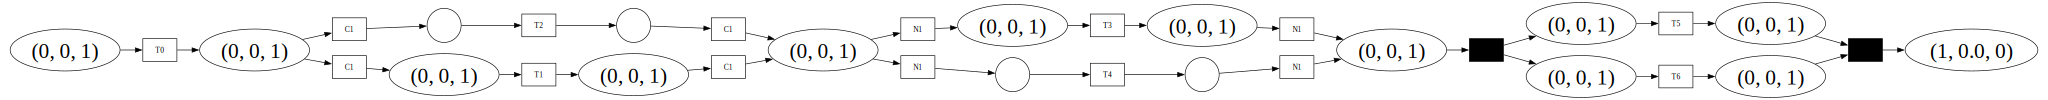

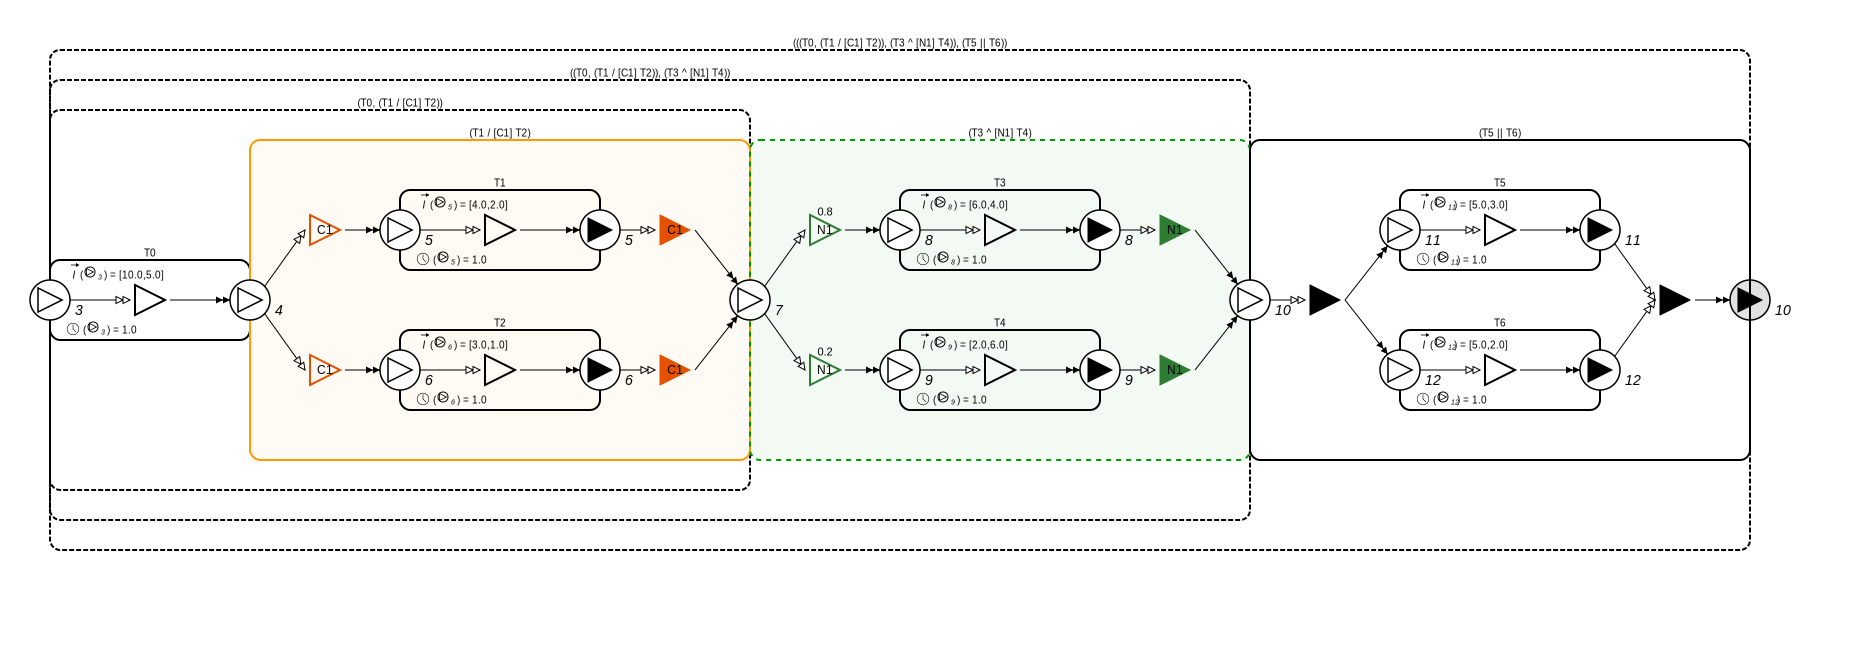

step 7/10: current_node=4


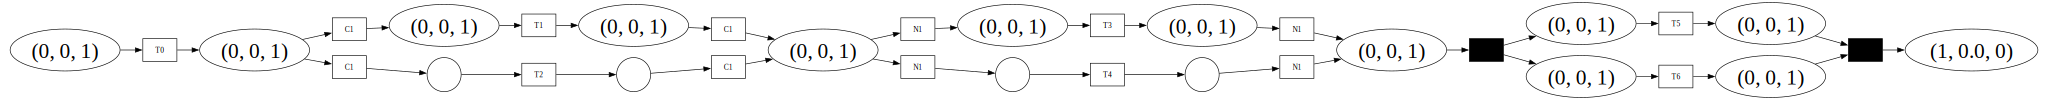

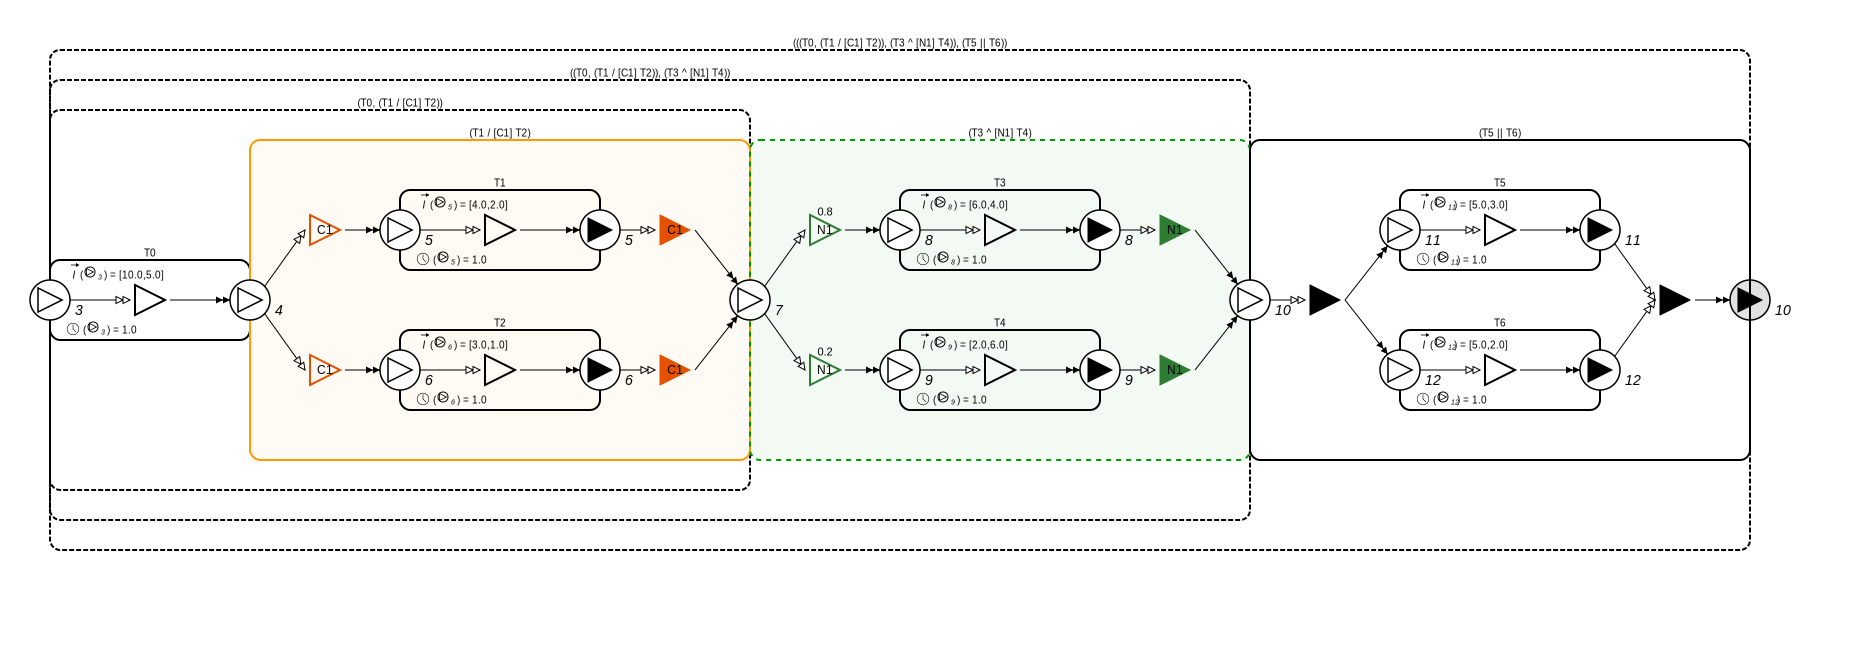

step 8/10: current_node=4


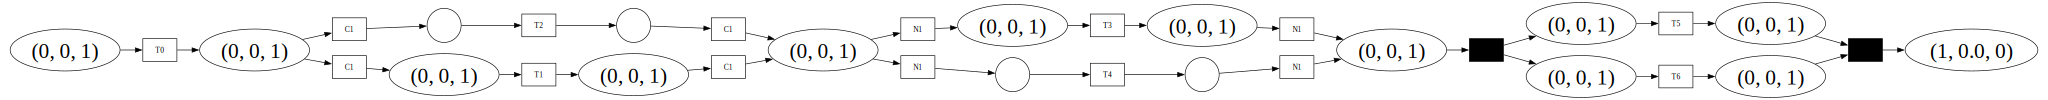

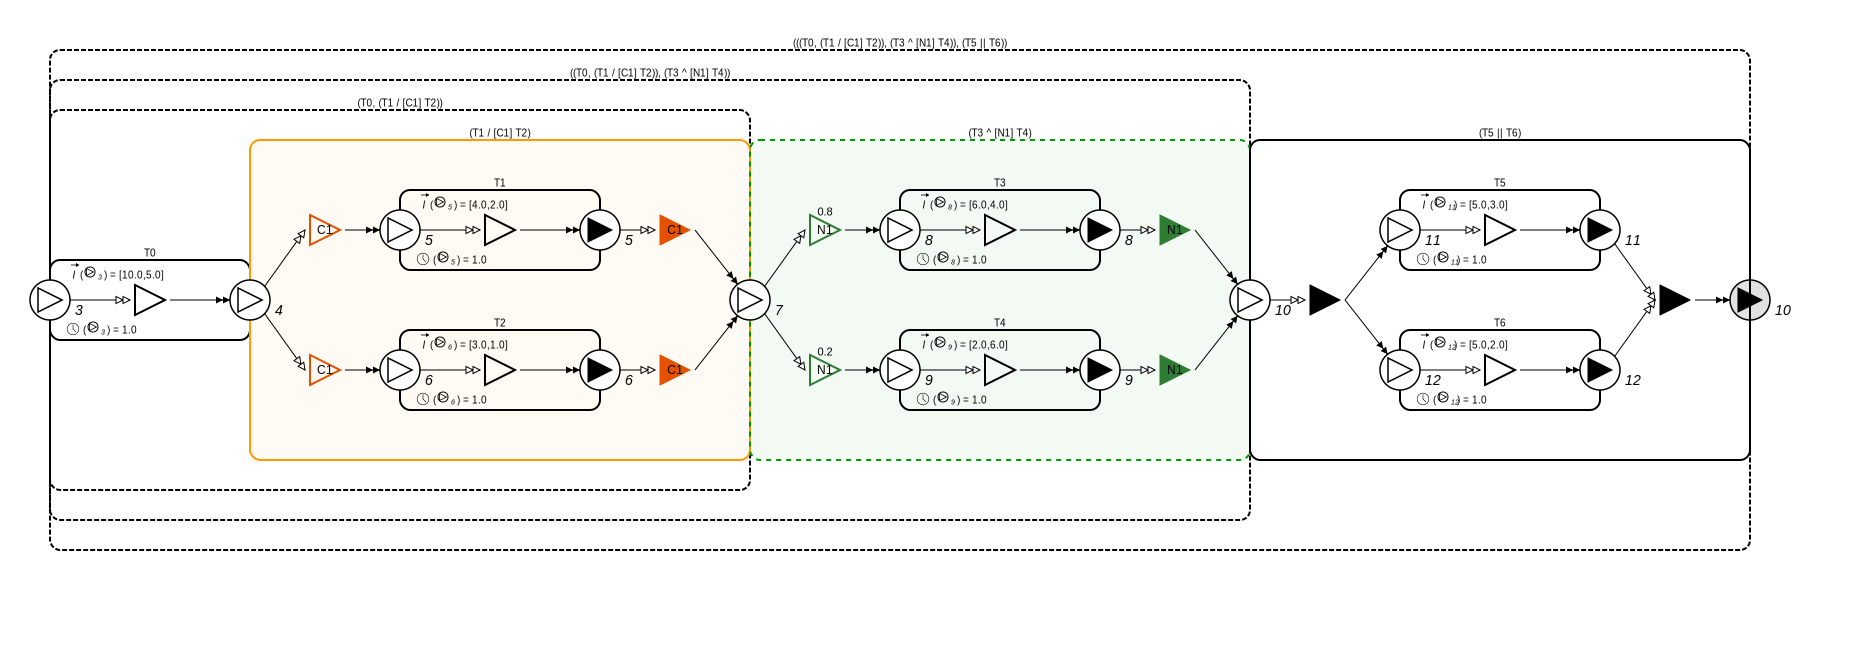

step 9/10: current_node=4


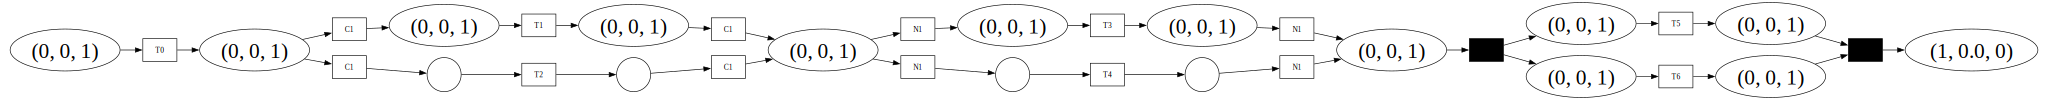

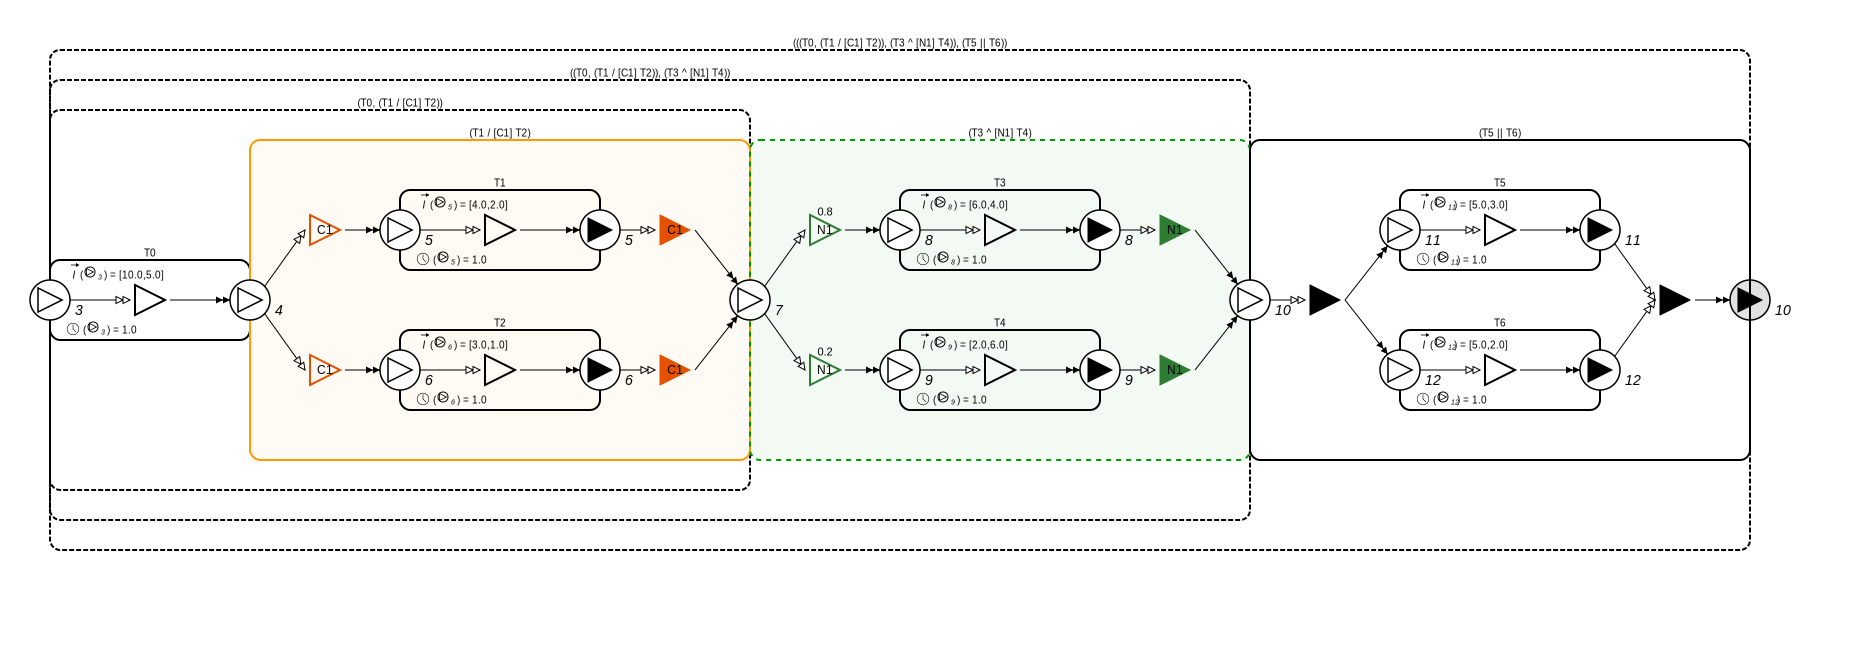

step 10/10: current_node=4


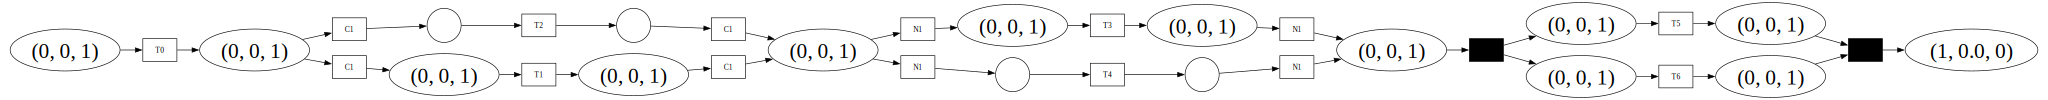

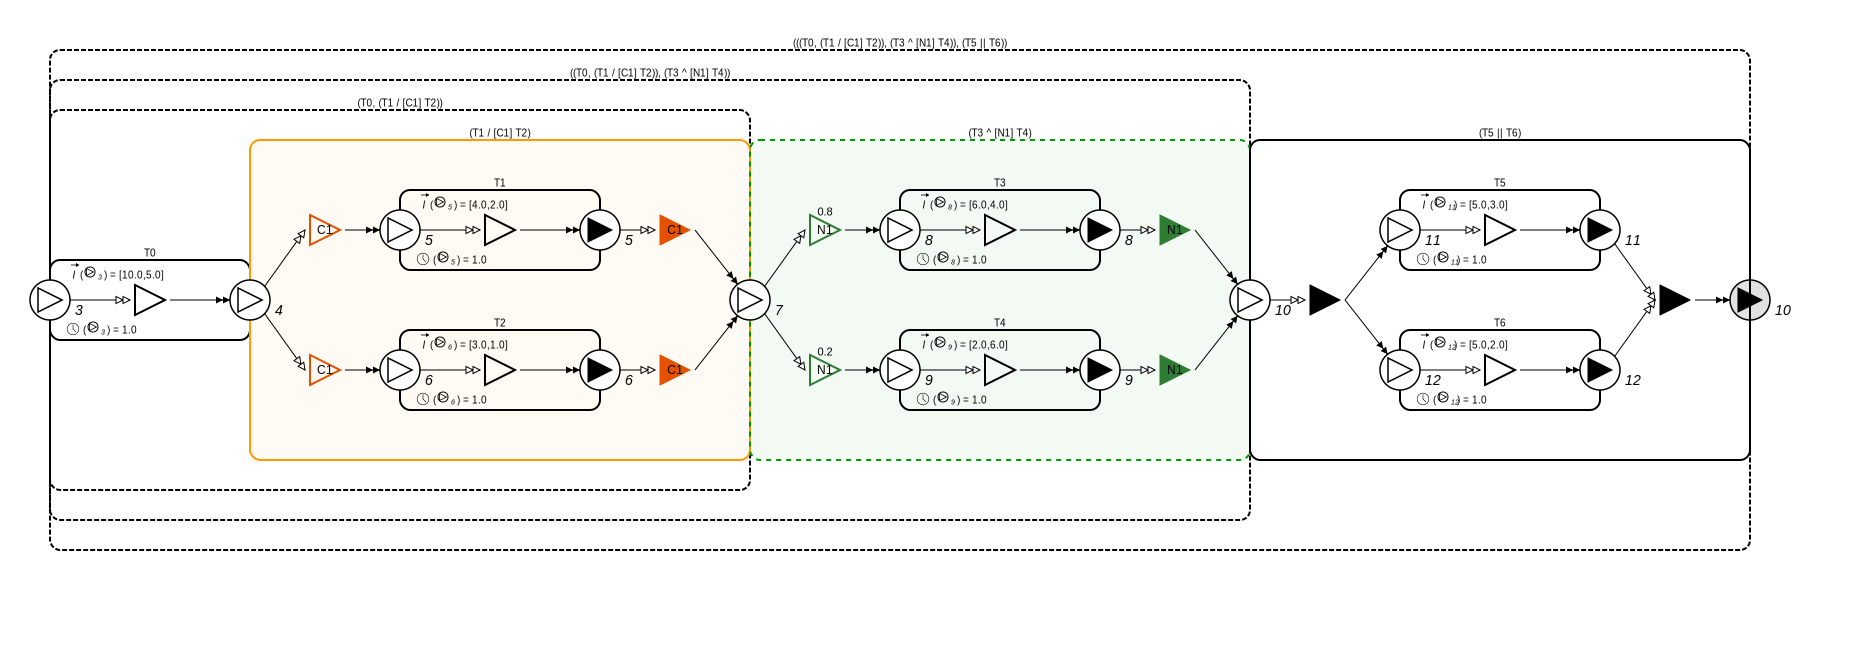

In [7]:
# Simulate for N seconds (1s per step)
steps = 10
for step in range(steps):
    request_json = {
        'bpmn': parse_tree,
        'petri_net': petri_net,
        'execution_tree': execution_tree,
        'time_step': 1.0,
        # 'choices': ['6']  # opzionale: transizioni stop da eseguire
    }

    response = requests.post(
        f"http://{URL}:{PORT}/execute",
        headers={"Content-Type": "application/json"},
        json=request_json,
    )
    response_json = response.json()
    if response_json.get('type') == 'error':
        raise RuntimeError(response_json.get('message', 'Unknown error'))

    parse_tree = response_json['bpmn']
    petri_net = response_json['petri_net']
    petri_net_dot = response_json['petri_net_dot']
    execution_tree = response_json['execution_tree']
    spin_svg = response_json.get('spin_svg')

    print(f"step {step + 1}/{steps}: current_node={execution_tree['current_node']}")
    graph = graphviz.Source(petri_net_dot, format="svg")
    display(graph)
    if spin_svg:
        display(SVG(spin_svg))


In [8]:
parse_tree = response_json['bpmn']
petri_net = response_json['petri_net']
petri_net_dot = response_json['petri_net_dot']
execution_tree = response_json['execution_tree']
spin_svg = response_json.get('spin_svg')


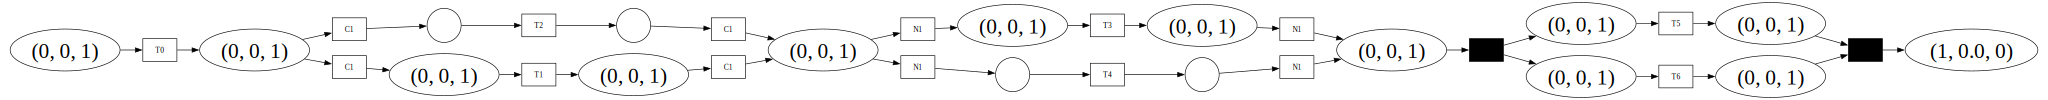

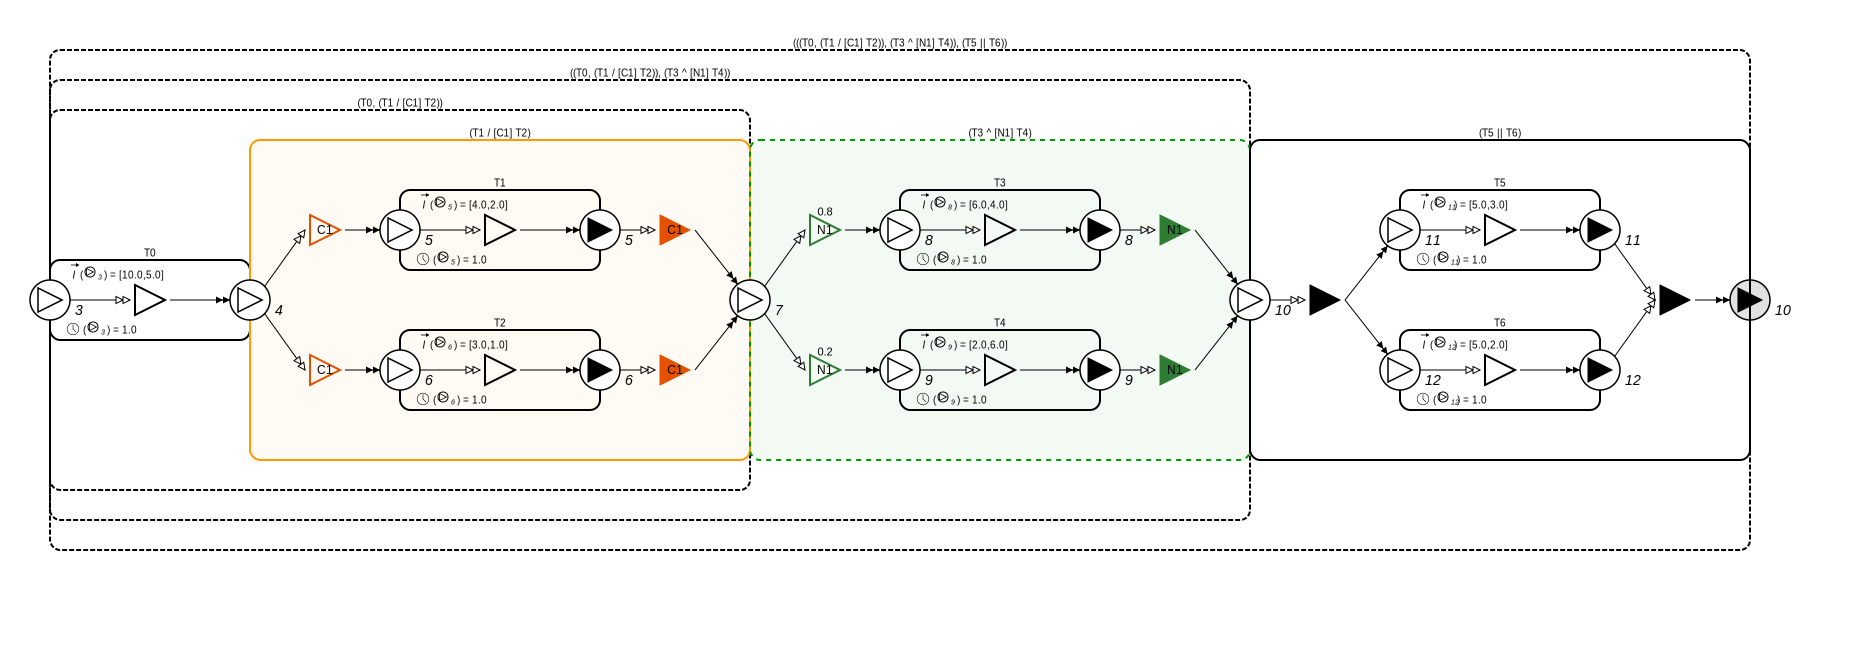

In [9]:
graph = graphviz.Source(petri_net_dot, format="svg")
display(graph)
if spin_svg:
    display(SVG(spin_svg))


--- Logging error ---
Traceback (most recent call last):
  File "C:\Python313\Lib\logging\handlers.py", line 80, in emit
    self.doRollover()
    ~~~~~~~~~~~~~~~^^
  File "C:\Python313\Lib\logging\handlers.py", line 185, in doRollover
    self.rotate(self.baseFilename, dfn)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python313\Lib\logging\handlers.py", line 121, in rotate
    os.rename(source, dest)
    ~~~~~~~~~^^^^^^^^^^^^^^
PermissionError: [WinError 32] Impossibile accedere al file. Il file è utilizzato da un altro processo: 'C:\\Users\\danie\\Projects\\GitHub\\PACO\\logs\\detailed.log' -> 'C:\\Users\\danie\\Projects\\GitHub\\PACO\\logs\\detailed.log.1'
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\danie\Projects\GitHub\PACO\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\danie\Projects\GitHub\PACO\venv\Lib\site-packages\

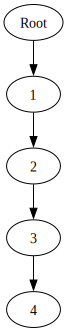

In [10]:
from model.endpoints.execute.request import ExecuteRequest

model = ExecuteRequest.model_validate_json(response.text)
extree = model.execution_tree_obj
extree_dot = "\n".join(DotExporter(extree.root))
display(graphviz.Source(extree_dot))

# Display BPMN

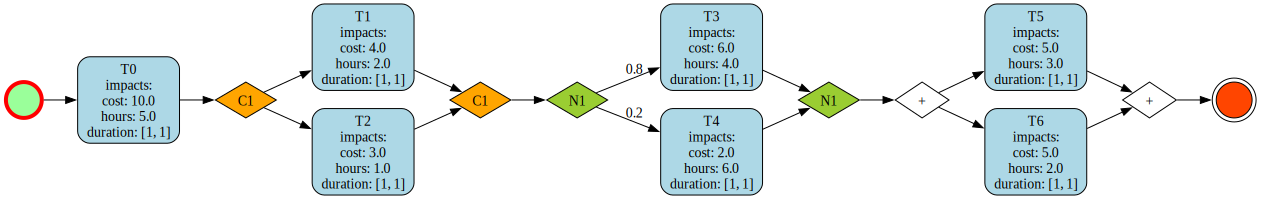

In [11]:


from dot import get_active_region_by_pn

impacts_names = ["a", "b"]
marking = {"21": {"token": 1}, "7": {"token": 1}}

resp = requests.get(f"http://{URL}:{8000}/create_bpmn",
					json={
						"bpmn": bpmn,
						"active_regions": list(get_active_region_by_pn(petri_net, marking)),
						"is_initial": False,
						"is_final": False
					},
					headers={"Content-Type": "application/json"})
resp.raise_for_status()

dot =  resp.json()["bpmn_dot"]
graph = graphviz.Source(dot, format="svg")

display(graph)

# Display Execution Tree

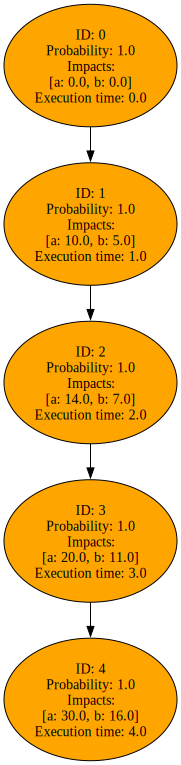

In [12]:
from src.paco.parser.dot.execution_tree import get_path_to_current_node, get_execution_tree_dot

current_path = get_path_to_current_node(execution_tree.get("root",{}), execution_tree.get("current_node"))
dot = get_execution_tree_dot(execution_tree.get("root", {}), impacts_names, current_path)
graph = graphviz.Source(dot, format="svg")
display(graph)